# Arquitetura CNN Simplificada para MNIST

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Carregamento e pré-processamento dos dados
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., None].astype("float32")
x_test = x_test[..., None].astype("float32")



# ============================================================================
# FUNÇÃO PARA COMPARAR MODELOS
# ============================================================================
def compare_models():
    """Compara diferentes arquiteturas"""
    models = {
        "Ultra-Simples": create_ultra_simple_model(),
        "Balanceado": create_balanced_model(),
        "Com Dropout": create_dropout_model()
    }

    results = {}

    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"TESTANDO: {name}")
        print(f"{'='*50}")

        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Mostra arquitetura
        model.summary()

        # Treina rapidamente
        history = model.fit(
            x_train, y_train,
            epochs=3,
            batch_size=128,
            validation_split=0.1,
            verbose=1
        )

        # Avalia
        loss, acc = model.evaluate(x_test, y_test, verbose=0)

        # Conta parâmetros
        params = model.count_params()

        results[name] = {
            'accuracy': acc,
            'parameters': params,
            'model': model
        }

        print(f"Acurácia: {acc:.4f}")
        print(f"Parâmetros: {params:,}")

    return results





"""def create_balanced_model():


   model = tf.keras.Sequential([
       tf.keras.layers.Input((28,28,1)),
       tf.keras.layers.Conv2D(10, 5, activation="relu", padding='same'),     # (28,28,1) -> (28,28,8)
       tf.keras.layers.MaxPool2D(2),                                        # (28,28,8) -> (14,14,8)
       tf.keras.layers.Conv2D(20, 3, activation="relu"),                    # (14,14,8) -> (12,12,16)
       tf.keras.layers.MaxPool2D(2),                                        # (12,12,16) -> (6,6,16)
       tf.keras.layers.GlobalAveragePooling2D(),                            # (6,6,16) -> (16,)
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(10, activation="softmax")
   ])
   return model
"""

def create_balanced_model():
    """
    Modelo balanceado aprimorado:
    - Adiciona uma segunda convolução leve para extrair mais recursos
    - Inclui BatchNormalization para acelerar e estabilizar o treino
    - Mantém o total de parâmetros próximo ou abaixo do original (~2 000 params)
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input((28, 28, 1)),
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model



# ============================================================================
#






# ============================================================================
# FUNÇÃO PARA CONVERTER PARA TFLITE
# ============================================================================
def convert_to_tflite(model, filename):
    """Converte modelo para TensorFlow Lite"""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Quantização adicional para modelos ainda menores
    converter.target_spec.supported_types = [tf.float16]

    tflite_model = converter.convert()

    with open(filename, "wb") as f:
        f.write(tflite_model)

    # Mostra tamanho do arquivo
    import os
    size_kb = os.path.getsize(filename) / 1024
    print(f"Modelo salvo em {filename} ({size_kb:.1f} KB)")

    return tflite_model

In [14]:
if __name__ == "__main__":
    # Opção 1: Testar modelo específico
    print("Criando modelo simples...")
    model = create_balanced_model()

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    # Treinar
    model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.1
    )

    # Avaliar
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia final: {acc:.4f}")

    # Converter para TFLite
    convert_to_tflite(model, "mnist_simple.tflite")
    #novo

Criando modelo simples...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098 (8.20 KB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3251 - loss: 1.9869 - val_accuracy: 0.3862 - val_loss: 1.7057
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8133 - loss: 0.8647 - val_accuracy: 0.9052 - val_loss: 0.4582
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8836 - loss: 0.4897 - val_accuracy: 0.9230 - val_loss: 0.3386
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9079 - loss: 0.3572 - val_accuracy: 0.9447 - val_loss: 0.2378
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9185 - loss: 0.2986 - val_accuracy: 0.9480 - val_loss: 0.1929
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9271 - loss: 0.2594 - val_accuracy: 0.9565 - val_loss: 0.1635
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9307 - loss: 0.2356 - val_accuracy: 0.9602 - val_loss: 0.1460
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9329 - loss: 0.2274 - val_accuracy: 

In [ ]:
# ============================================================================
# EXEMPLO DE USO
# ============================================================================
if __name__ == "__main__":
    # Opção 1: Testar modelo específico
    print("Criando modelo simples...")
    model = create_balanced_model()

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    # Treinar
    model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        validation_split=0.1
    )

    # Avaliar
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Acurácia final: {acc:.4f}")

    # Converter para TFLite
    convert_to_tflite(model, "mnist_simple.tflite")



Criando modelo simples...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 12)       │         1,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 12)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098 (8.20 KB)

 Trainable params: 2,098 (8.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3059 - loss: 2.0060 - val_accuracy: 0.7450 - val_loss: 0.8666
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7698 - loss: 0.7981 - val_accuracy: 0.8578 - val_loss: 0.5208
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8408 - loss: 0.5424 - val_accuracy: 0.8822 - val_loss: 0.4109
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8706 - loss: 0.4412 - val_accuracy: 0.9060 - val_loss: 0.3474
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8874 - loss: 0.3824 - val_accuracy: 0.9078 - val_loss: 0.3213
Acurácia final: 0.8992
Saved artifact at '/tmp/tmpexv2eexk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137731809556816: TensorSpec(shape=(), dtype=tf.resourc

# Q8

In [17]:


def convert_to_tflite_quantized(keras_model, representative_data, filename="mnist_cnn_small_int8.tflite"):
    """
    Converte um modelo Keras para TensorFlow Lite com quantização completa de inteiros (INT8).

    Args:
        keras_model: O modelo Keras treinado.
        representative_data: Um subconjunto de dados de entrada (ex: 100-200 amostras do x_train)
                             para calibrar a quantização. Deve ter o mesmo formato e tipo (float32)
                             da entrada do modelo original.
        filename: O nome do arquivo .tflite a ser salvo.
    """
    print("Iniciando a conversão para TFLite com quantização completa de inteiros...")

    # 1. Função geradora para o conjunto de dados representativo
    def representative_dataset_gen():
        for i in range(len(representative_data)):
            # O formato deve ser uma lista de tensores de entrada
            yield [representative_data[i:i+1]]

    # 2. Crie o conversor a partir do modelo Keras
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

    # 3. Defina as otimizações e configurações de quantização
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen

    # 4. (MAIS IMPORTANTE) Força a quantização de inteiros para todas as operações.
    # Isso evita o erro de "modelo híbrido" no ESP32.
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

    # 5. Define os tipos de tensores de entrada e saída como inteiros de 8 bits
    converter.inference_input_type = tf.int8  # Entrada agora é int8
    converter.inference_output_type = tf.int8 # Saída agora é int8

    # 6. Realiza a conversão
    tflite_quant_model = converter.convert()

    # 7. Salva o modelo no arquivo
    with open(filename, "wb") as f:
        f.write(tflite_quant_model)

    print(f"✅ Modelo quantizado (INT8) salvo com sucesso em: {filename}")
    return tflite_quant_model

# --- COMO USAR A FUNÇÃO ---

# 1. Prepare o conjunto de dados representativo (um pequeno subconjunto é suficiente)
# Use os dados de treino normalizados (float32) que você já tem.
representative_data = x_train[:200]

# 2. Chame a função para converter e salvar o modelo quantizado
# O modelo 'model' deve estar treinado neste ponto.
quantized_tflite_model = convert_to_tflite_quantized(model, representative_data)


# --- (OPCIONAL, MAS RECOMENDADO) Verificando a inferência com o modelo quantizado ---
print("\nVerificando a inferência com o modelo INT8...")

# Índice da imagem no batch de teste
index = 4

# Prepara o sample (float32) e recupera o rótulo verdadeiro
sample_float = x_test[index : index+1]  # shape (1, 28, 28, 1), tipo float32
true_label = y_test[index]
print(f"Classe verdadeira: {true_label}")

# Carrega o novo modelo quantizado
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

# Obtém os detalhes de entrada e saída
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Quantiza a entrada (float32 -> int8), simulando o que o C++ faz
input_scale, input_zero_point = input_details["quantization"]
sample_quantized = (sample_float / input_scale + input_zero_point).astype(input_details["dtype"])

# Faz a inferência
interpreter.set_tensor(input_details["index"], sample_quantized)
interpreter.invoke()

# Obtém a saída bruta (int8)
pred_quantized = interpreter.get_tensor(output_details["index"])

# Desquantiza a saída (int8 -> float32) para interpretar os scores
output_scale, output_zero_point = output_details["quantization"]
pred_float = (pred_quantized.astype(np.float32) - output_zero_point) * output_scale

print(f"Dígito previsto (INT8): {np.argmax(pred_float)}")
print("Verificação concluída.")


# --- (OPCIONAL) Código para gerar o array C++ da imagem de teste ---
# Este código pode ser usado para gerar o array 'mnist_sample' do seu C++
# para garantir que você está testando a mesma imagem no Python e no ESP32.
# ... (seu código para gerar o array C++ continua o mesmo) ...


Iniciando a conversão para TFLite com quantização completa de inteiros...
Saved artifact at '/tmp/tmp1zz9acdq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_50')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133762970269264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966258704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966269264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966268112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966258128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966264656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966267344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966257744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133762966267536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13376296

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


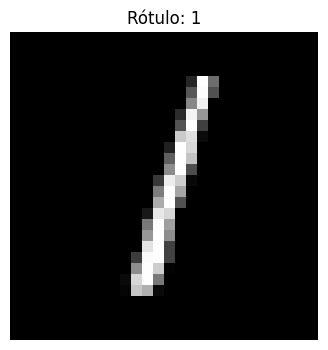

Classe verdadeira: 1
uint8_t mnist_sample[28*28] = {
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  38, 254, 109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 252, 82, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 135, 241, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 45, 244, 150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84,
  254, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 202, 223, 11, 0, 0,
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  0, 0, 0, 0, 0, 0, 

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# 1. Carrega MNIST
(_, _), (x_test, y_test) = mnist.load_data()

# 2. Seleciona a imagem e o rótulo
idx = 10



# 2. Recupera a imagem e o rótulo
img = x_test[idx].squeeze()      # squeeze() transforma (28,28,1) em (28,28)
label = y_test[idx]

# 3. Plota
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title(f"Rótulo: {label}")
plt.axis('off')
plt.show()



img = x_test[idx]
label = y_test[idx]
print(f"Classe verdadeira: {label}")



# 3. Achata e imprime os pixels no formato C
flat = img.flatten().astype(int)
lines = []
for i in range(0, len(flat), 16):
    chunk = flat[i:i+16]
    line = ", ".join(f"{p}" for p in chunk)
    lines.append("  " + line)
print("uint8_t mnist_sample[28*28] = {")
print(",\n".join(lines))
print("};")
